In [1]:
#!/usr/bin/env python
# coding: utf-8

import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import seisbench.models as sbm

sns.set(font_scale=1.2)
sns.set_style("ticks")


In [2]:
# Load the picker
picker = sbm.EQTransformer.from_pretrained("original")
print(picker.weights_docstring)

Original (conservative) EQTransformer model from Mousavi et al. (2020). Originally published under MIT License. Original available at https://github.com/smousavi05/EQTransformer/blob/01bf112a00c1a3bbb43adb2c7dba3e21b5fbcdb9/ModelsAndSampleData/EqT_model_conservative.h5 . 

Converted to SeisBench by Jannes Münchmeyer (munchmej@gfz-potsdam.de) and Calum Chamberlain (calum.chamberlain@vuw.ac.nz).


In [3]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

# Initialize the client
client = Client("GFZ")

# Define time window
t0 = UTCDateTime("2014/05/01 00:00:00")
t1 = t0 + 5 * 60

# Fetch waveforms for stations with the pattern "PB??"
stream = client.get_waveforms(network="CX", station="*", location="*", channel="HH?", starttime=t0, endtime=t1)

# Print the stream details (to see what we fetched)
print(stream.__str__(extended=True))

# Get a unique list of station names from the stream
station_names = set(trace.stats.station for trace in stream)

# Create a dictionary to store the sliced streams
station_streams = {}

# Iterate through the station names and slice the stream for each station
for station in station_names:
    # Slice the stream for the current station and store it in the dictionary
    station_streams[station] = stream.select(station=station)
    print(f"\n{station} Stream:")
    print(station_streams[station].__str__(extended=True))

# Now, station_streams contains a dictionary with the station name as the key and the corresponding stream as the value


54 Trace(s) in Stream:
CX.PB01..HHZ  | 2014-04-30T23:59:59.998393Z - 2014-05-01T00:04:59.998393Z | 100.0 Hz, 30001 samples
CX.PB01..HHE  | 2014-04-30T23:59:59.998393Z - 2014-05-01T00:04:59.998393Z | 100.0 Hz, 30001 samples
CX.PB01..HHN  | 2014-04-30T23:59:59.998391Z - 2014-05-01T00:04:59.998391Z | 100.0 Hz, 30001 samples
CX.PB02..HHZ  | 2014-04-30T23:59:59.998393Z - 2014-05-01T00:04:59.998393Z | 100.0 Hz, 30001 samples
CX.PB02..HHE  | 2014-04-30T23:59:59.998393Z - 2014-05-01T00:04:59.998393Z | 100.0 Hz, 30001 samples
CX.PB02..HHN  | 2014-04-30T23:59:59.998393Z - 2014-05-01T00:04:59.998393Z | 100.0 Hz, 30001 samples
CX.PB03..HHZ  | 2014-04-30T23:59:59.998391Z - 2014-05-01T00:04:59.998391Z | 100.0 Hz, 30001 samples
CX.PB03..HHE  | 2014-04-30T23:59:59.998391Z - 2014-05-01T00:04:59.998391Z | 100.0 Hz, 30001 samples
CX.PB03..HHN  | 2014-04-30T23:59:59.998391Z - 2014-05-01T00:04:59.998391Z | 100.0 Hz, 30001 samples
CX.PB04..HHZ  | 2014-04-30T23:59:59.998393Z - 2014-05-01T00:04:59.998393Z | 1

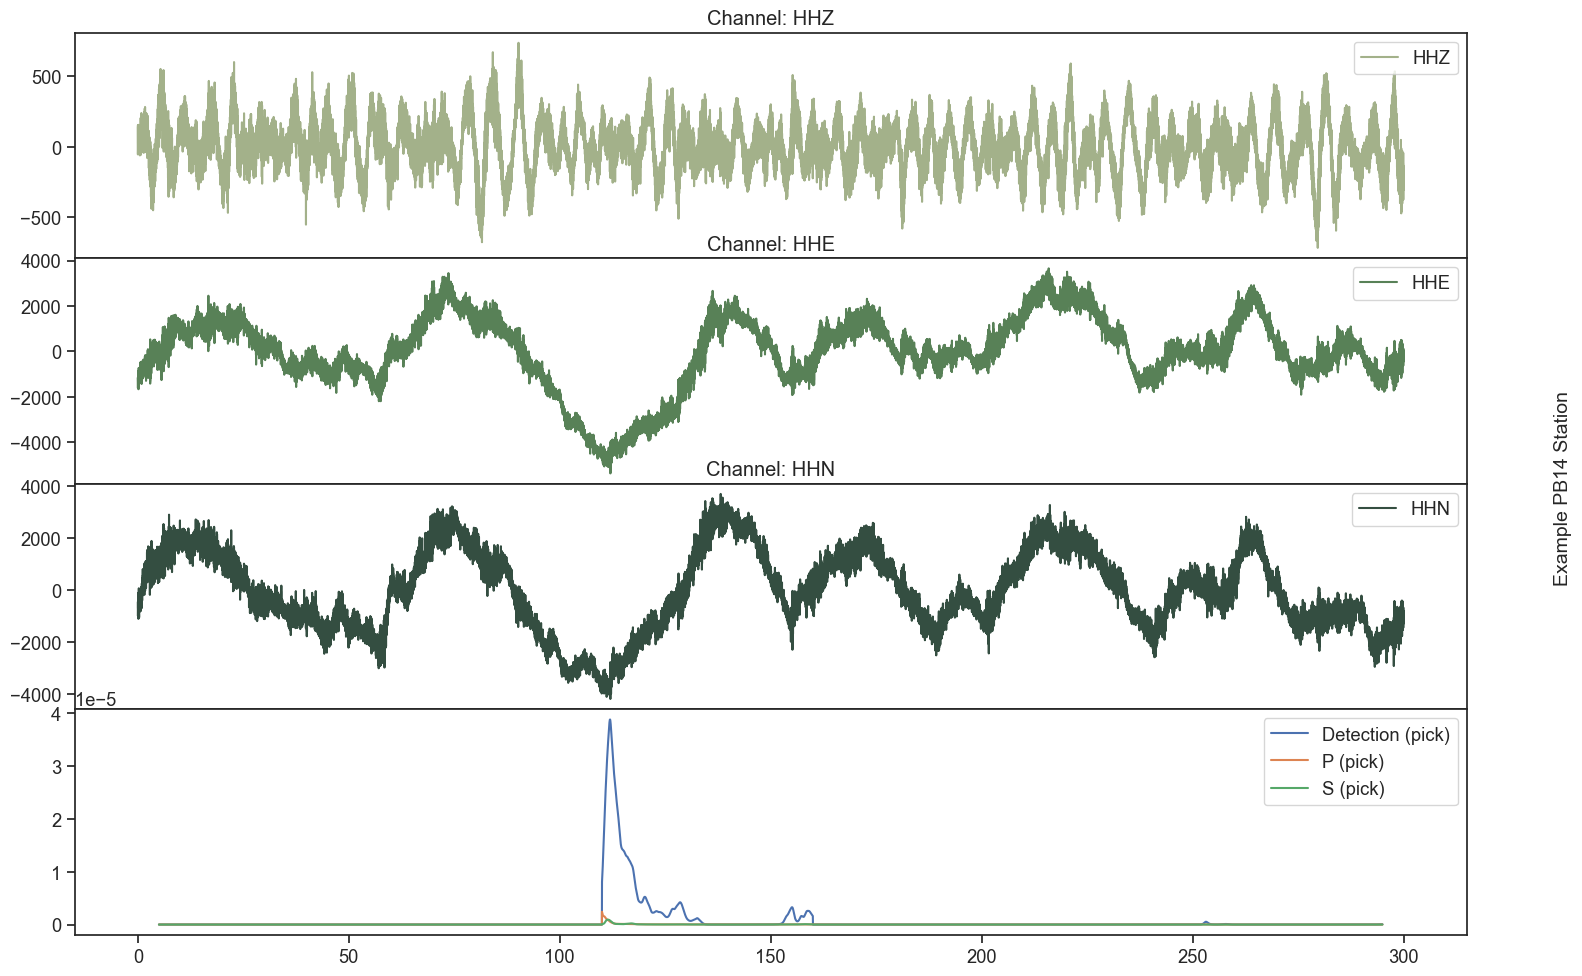

Plot for station PB14 with annotations saved.


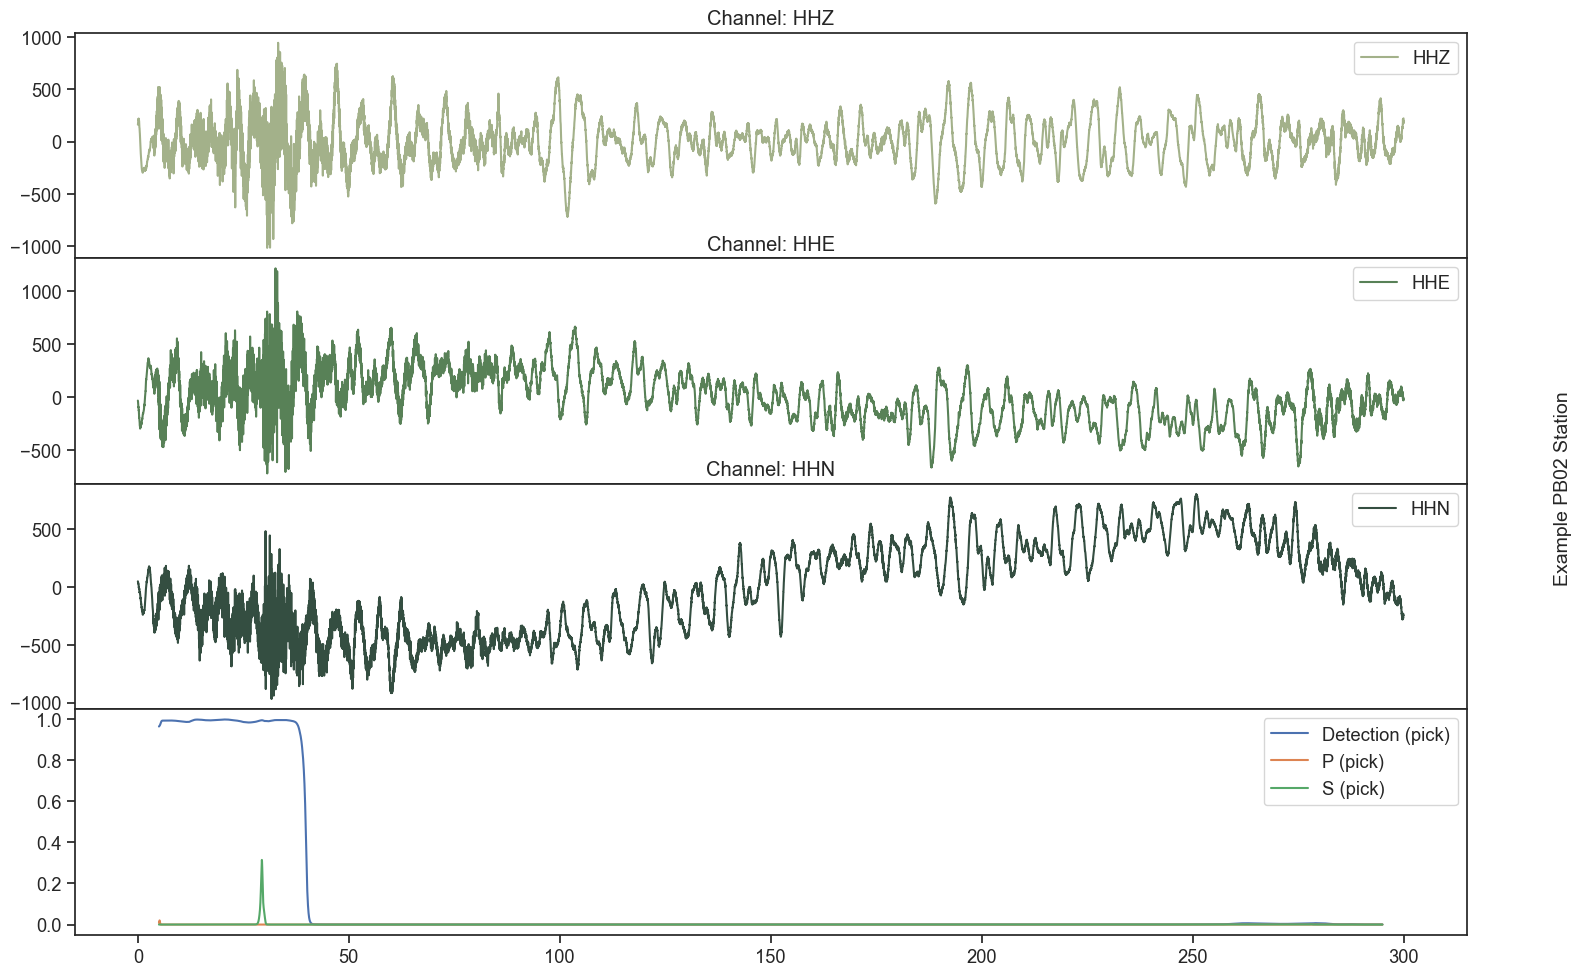

Plot for station PB02 with annotations saved.


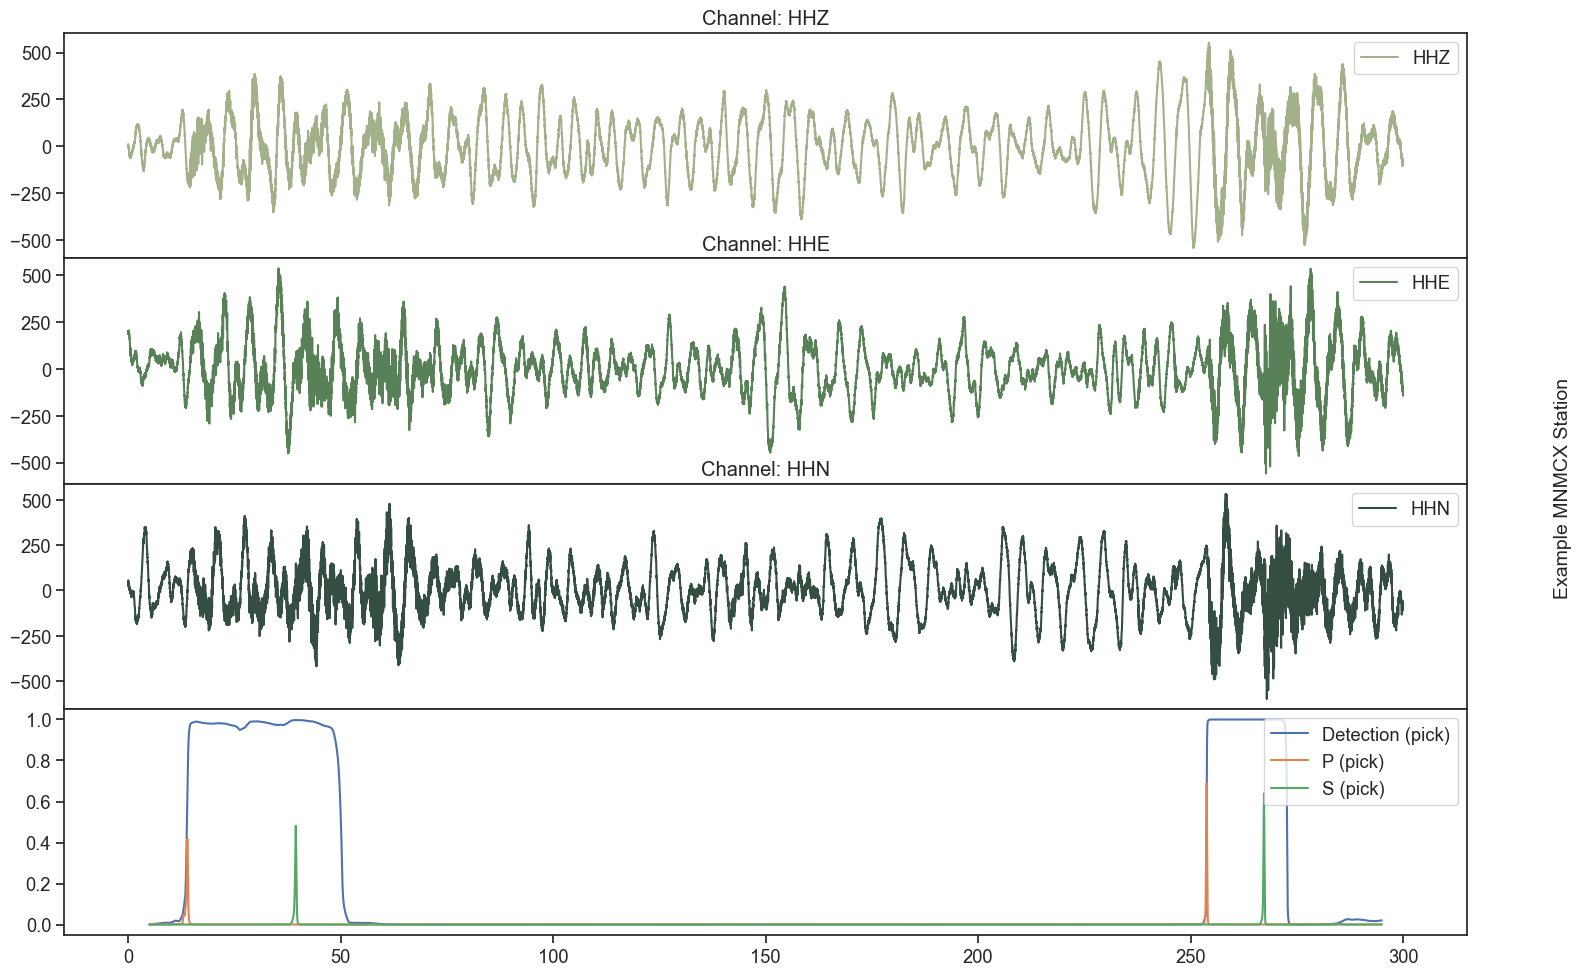

Plot for station MNMCX with annotations saved.


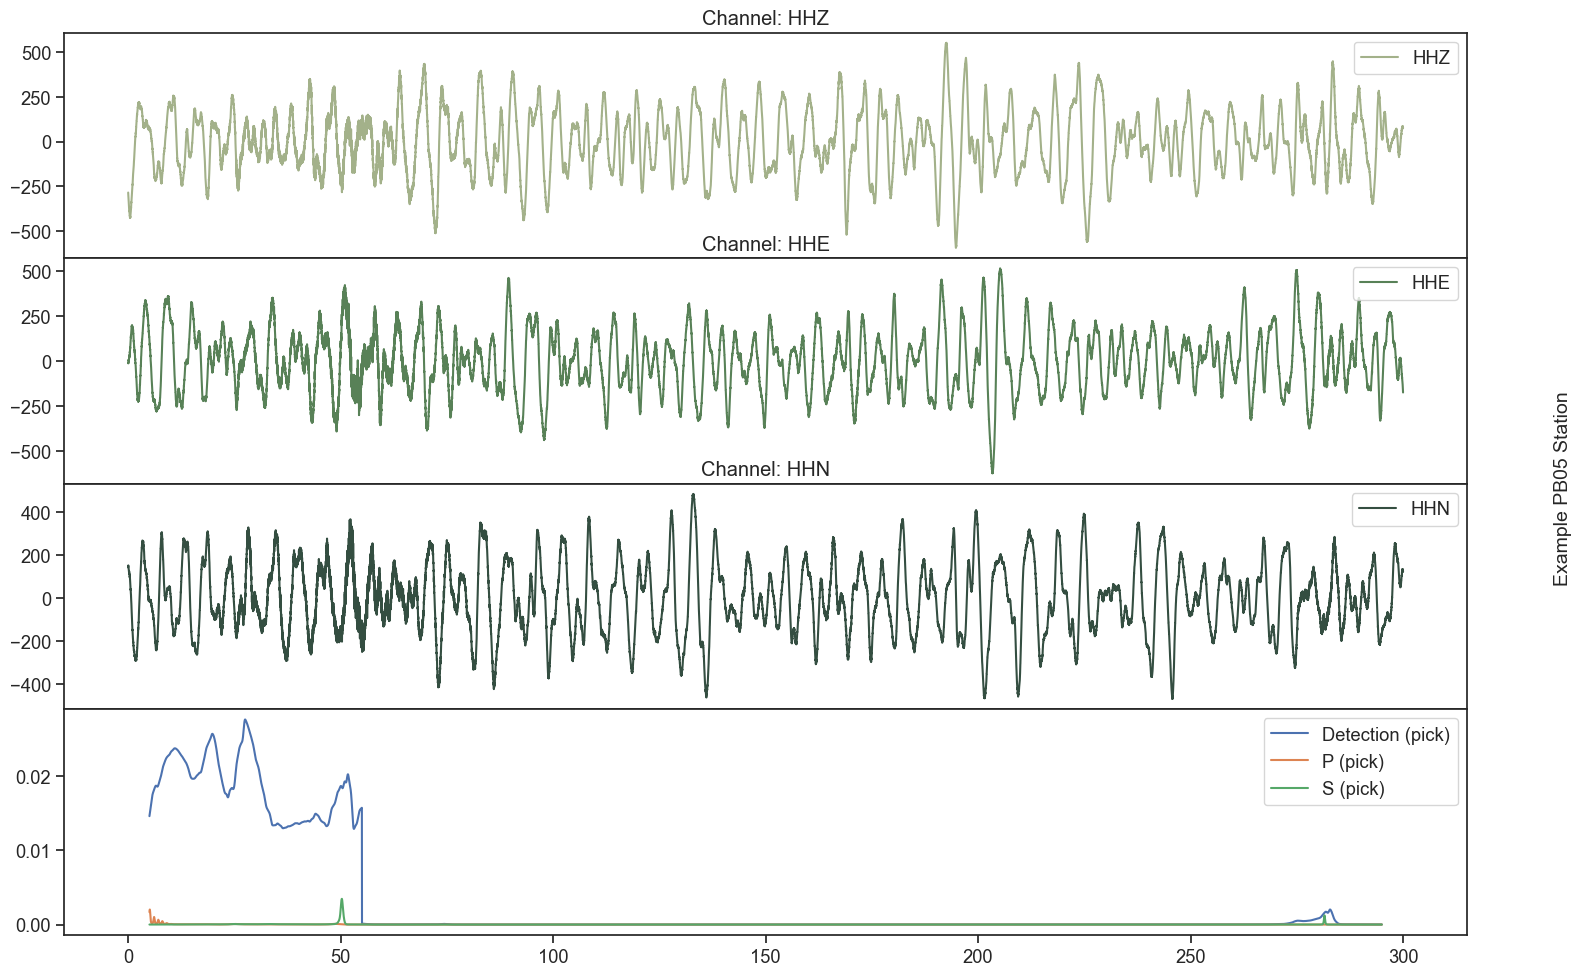

Plot for station PB05 with annotations saved.


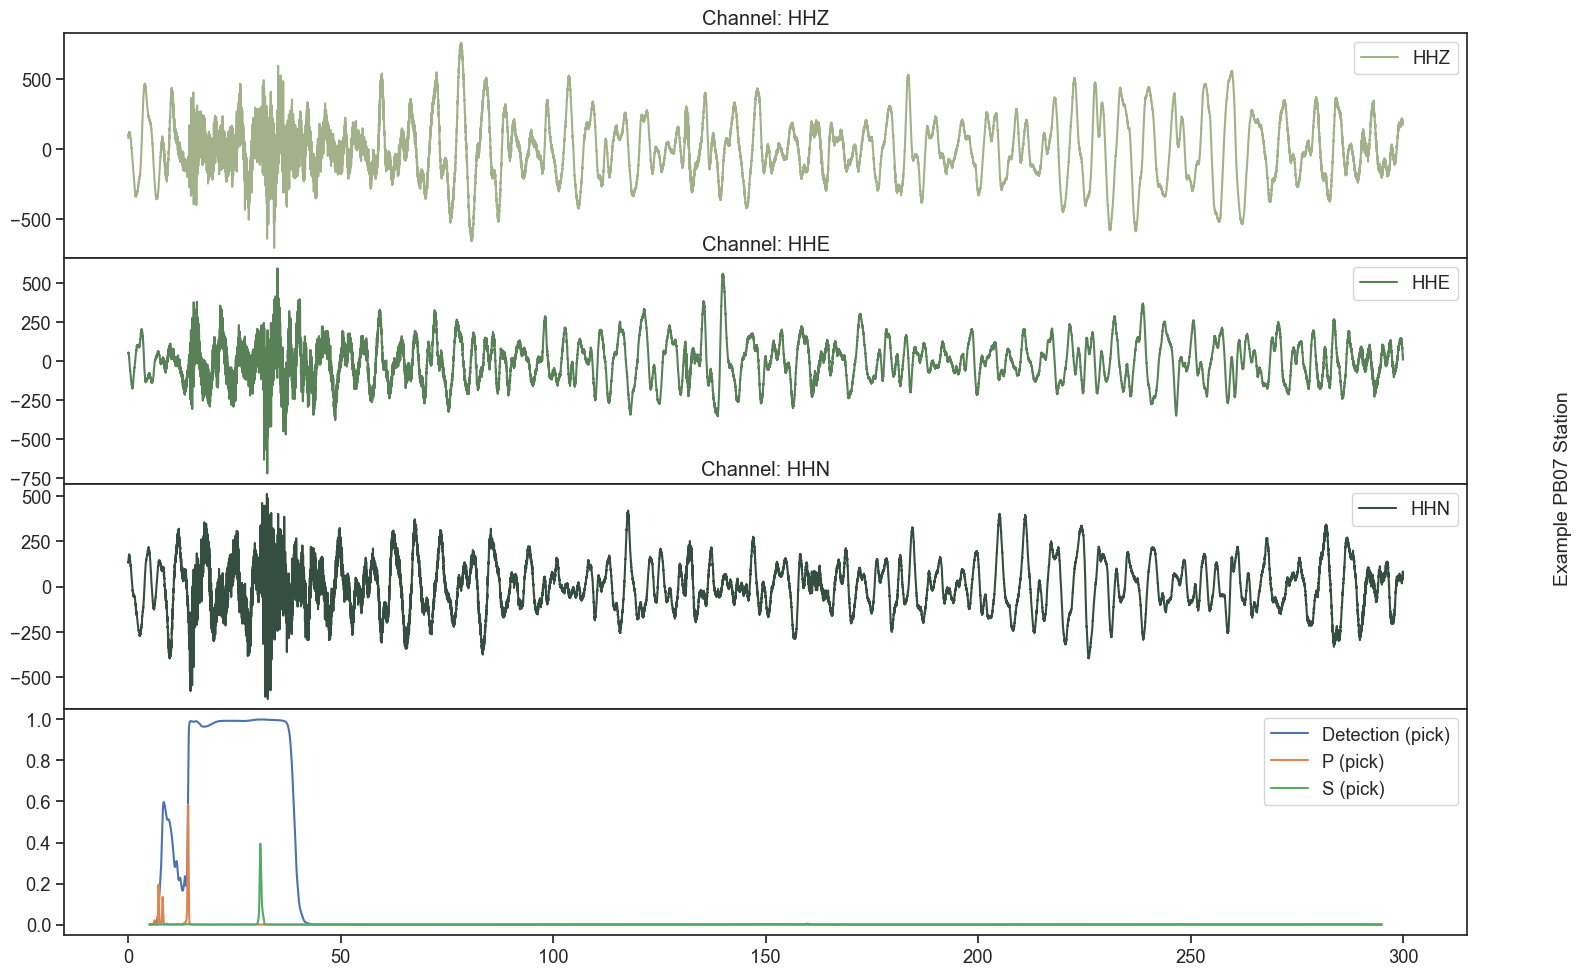

Plot for station PB07 with annotations saved.


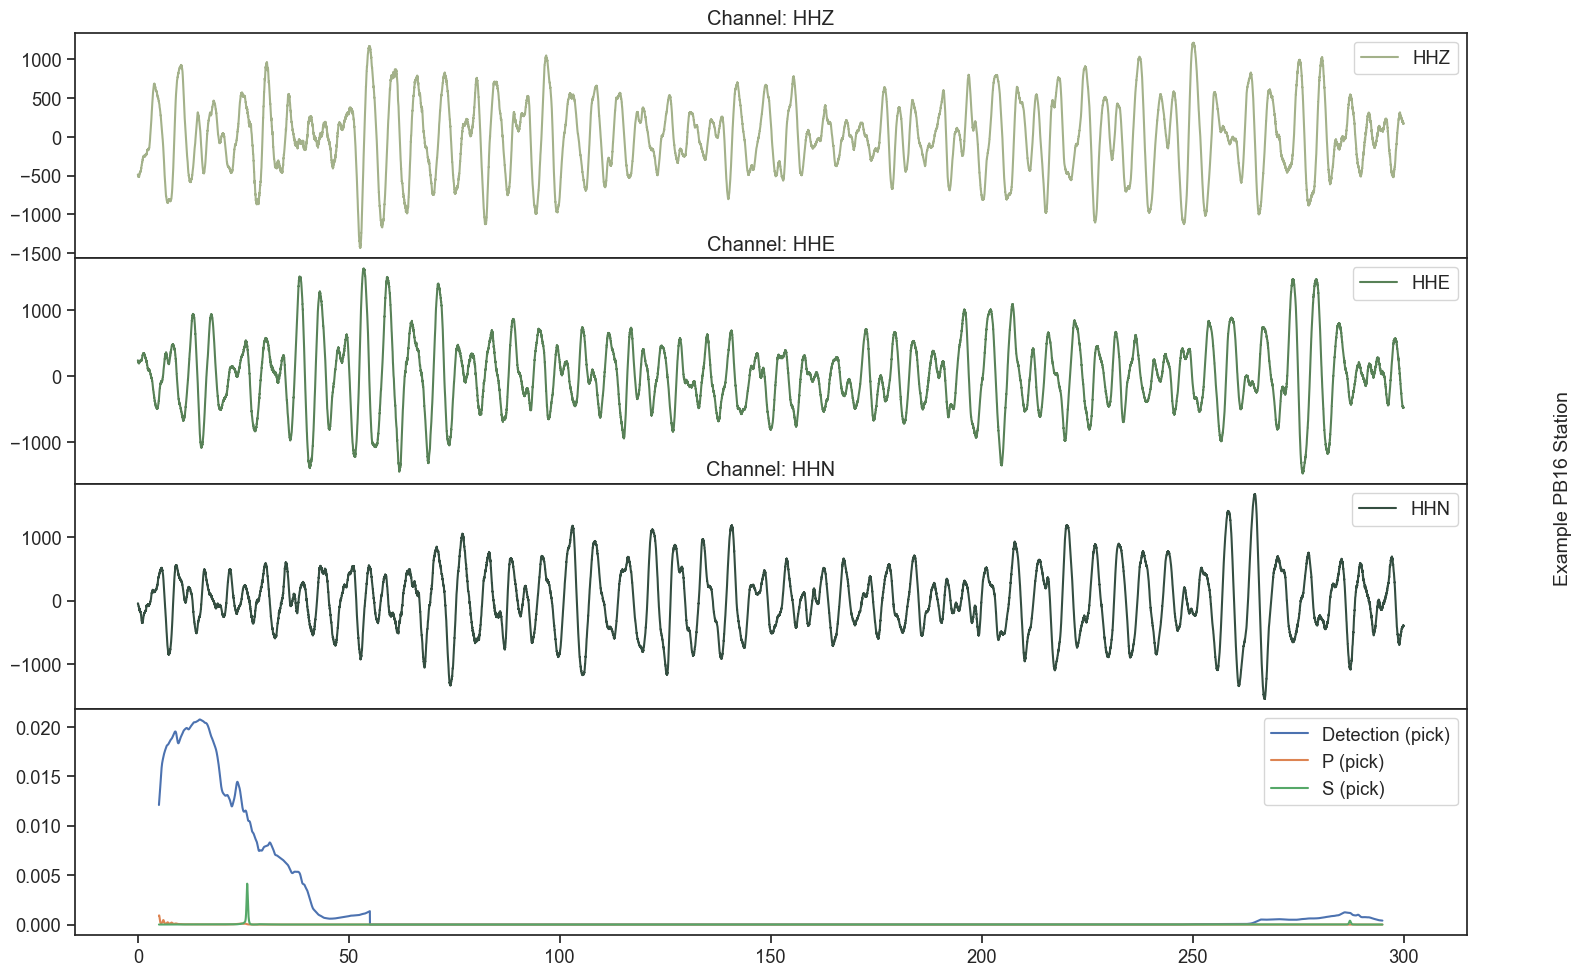

Plot for station PB16 with annotations saved.


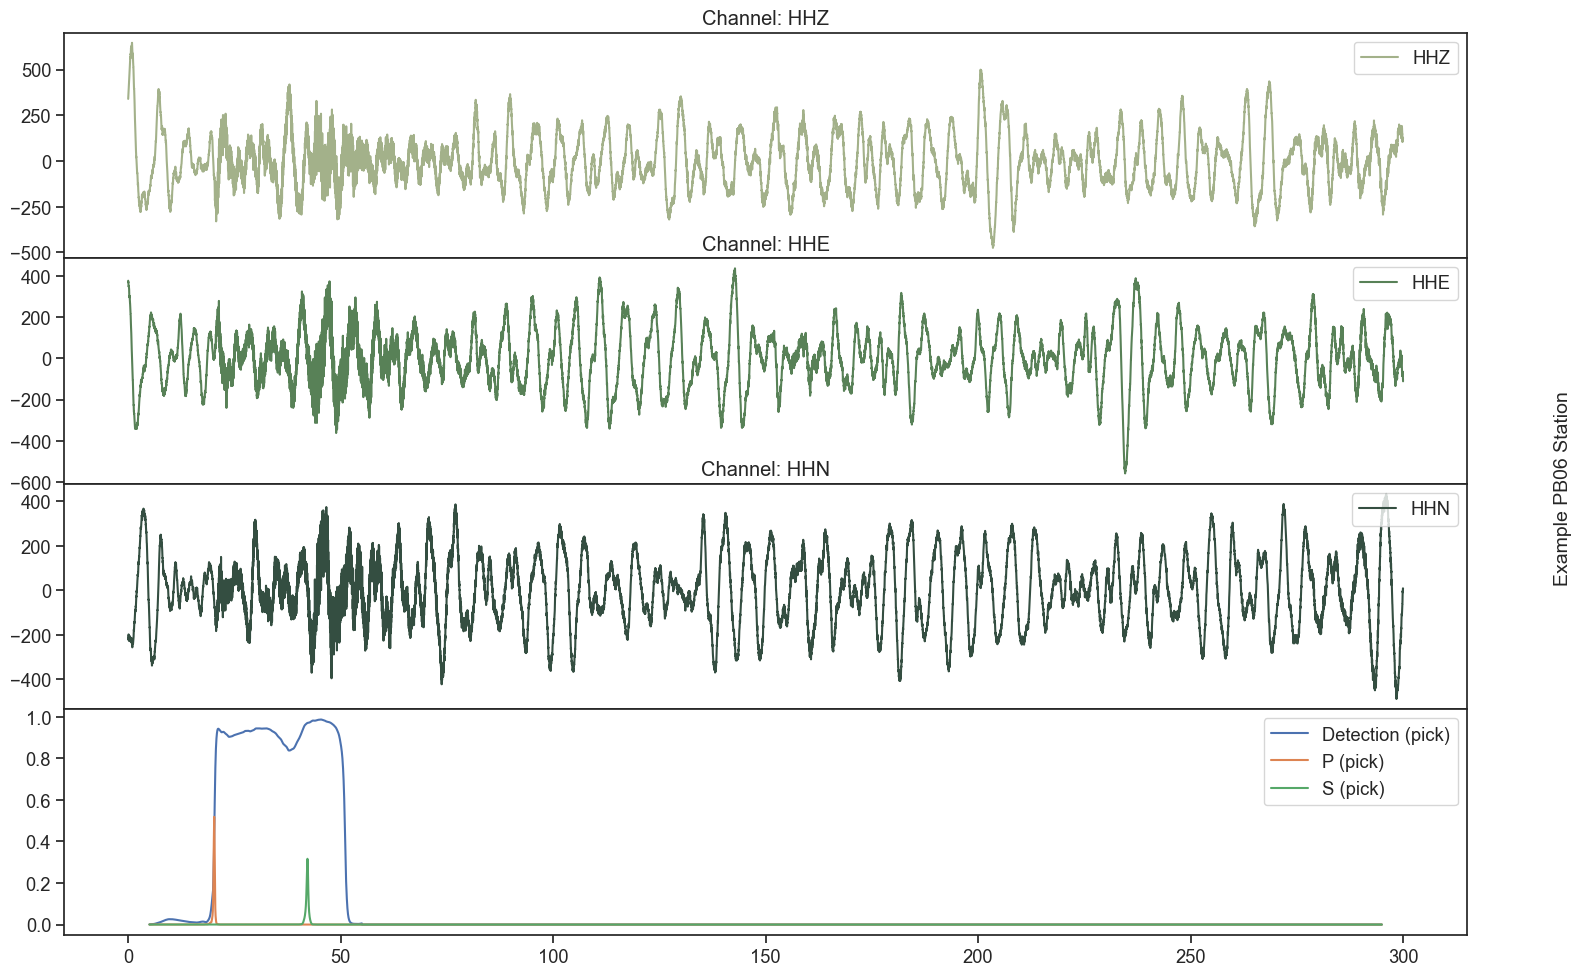

Plot for station PB06 with annotations saved.


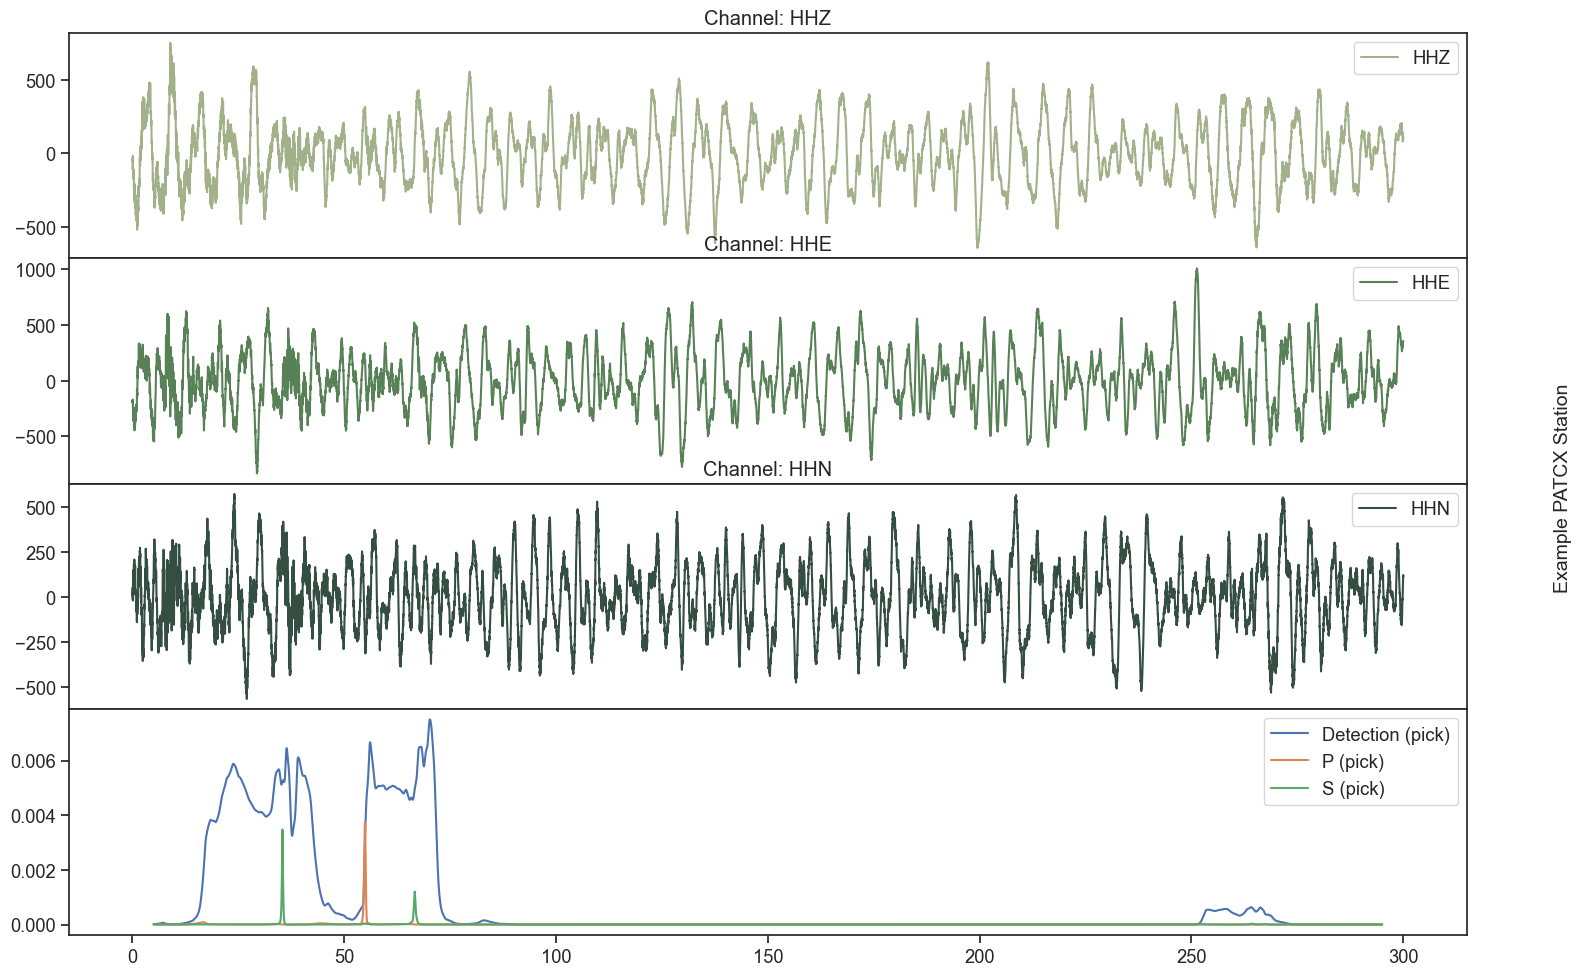

Plot for station PATCX with annotations saved.


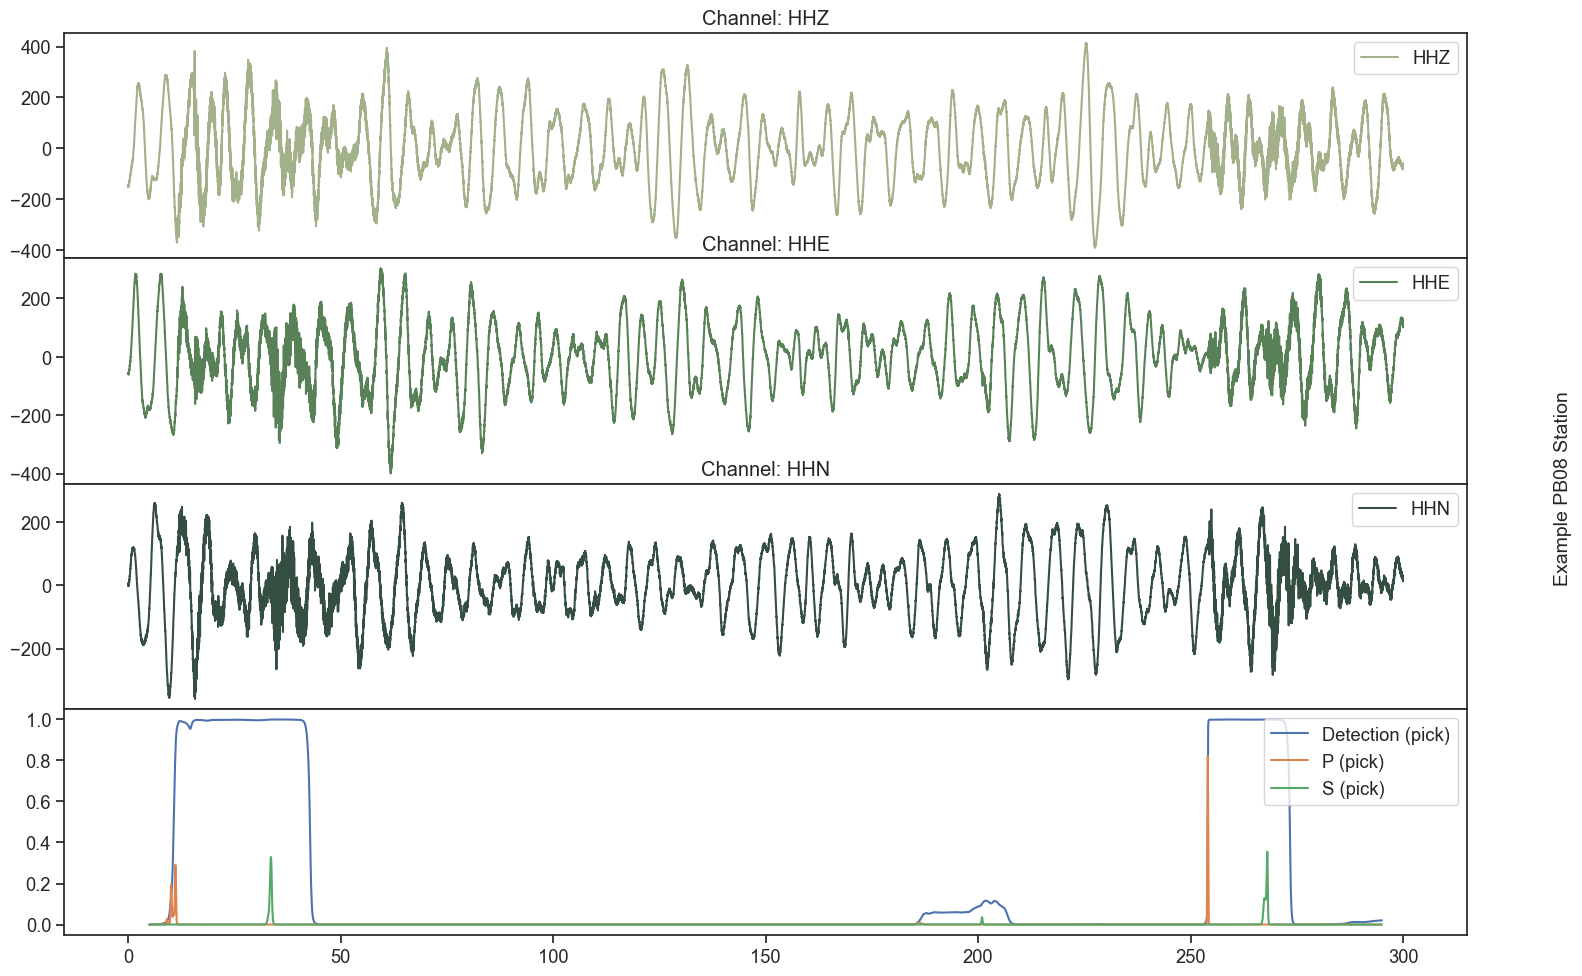

Plot for station PB08 with annotations saved.


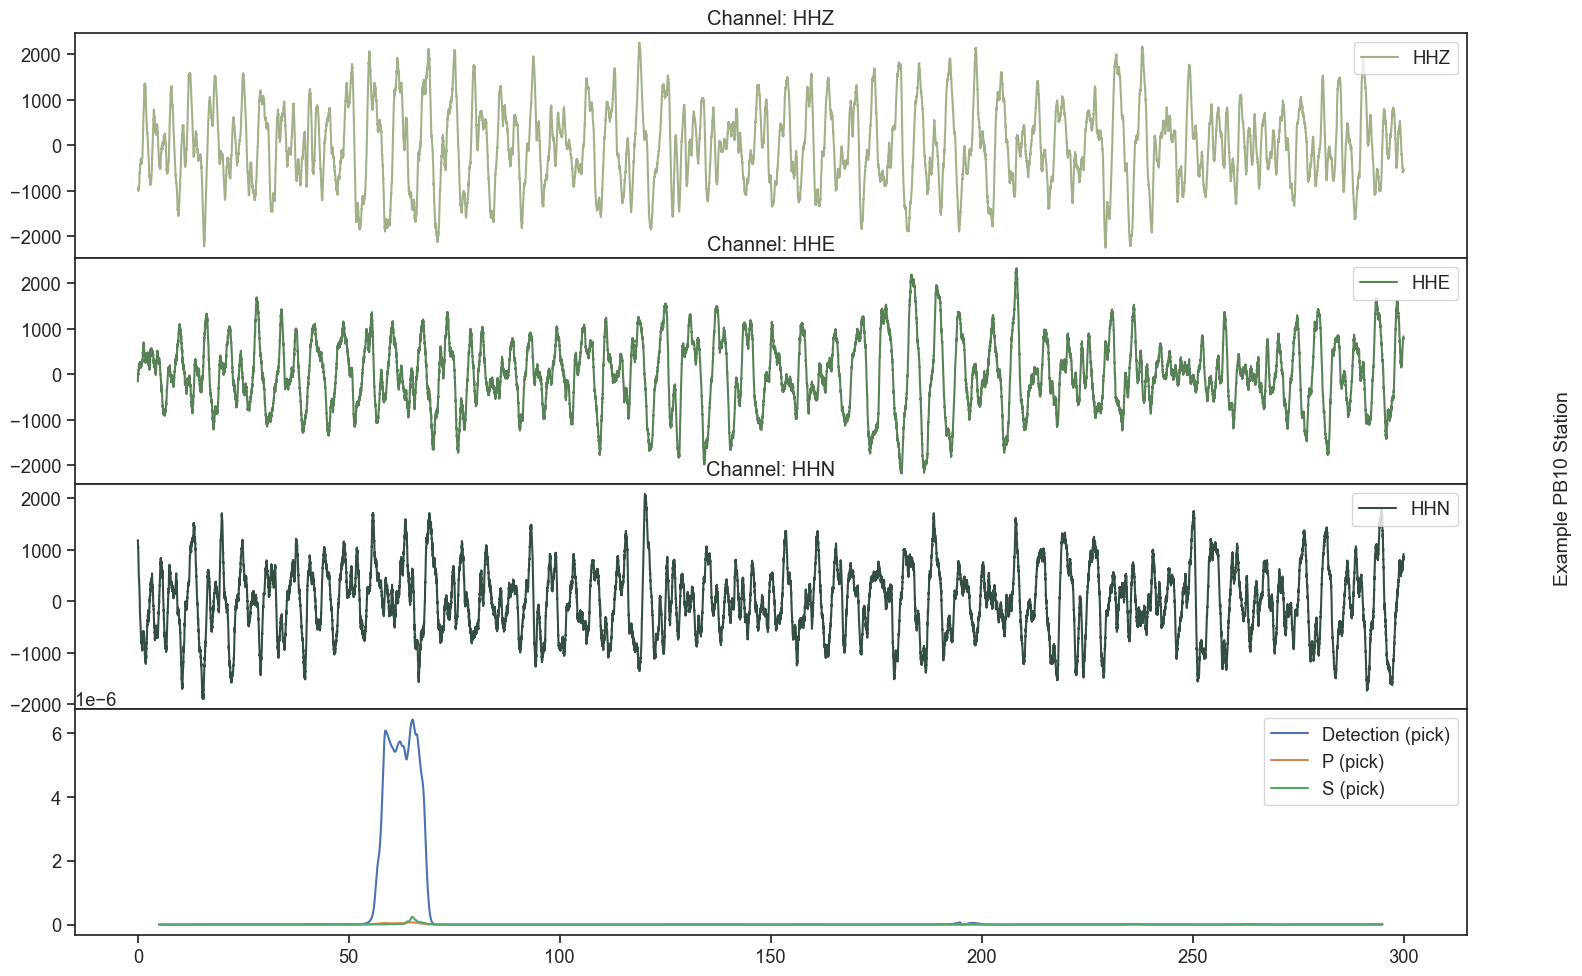

Plot for station PB10 with annotations saved.


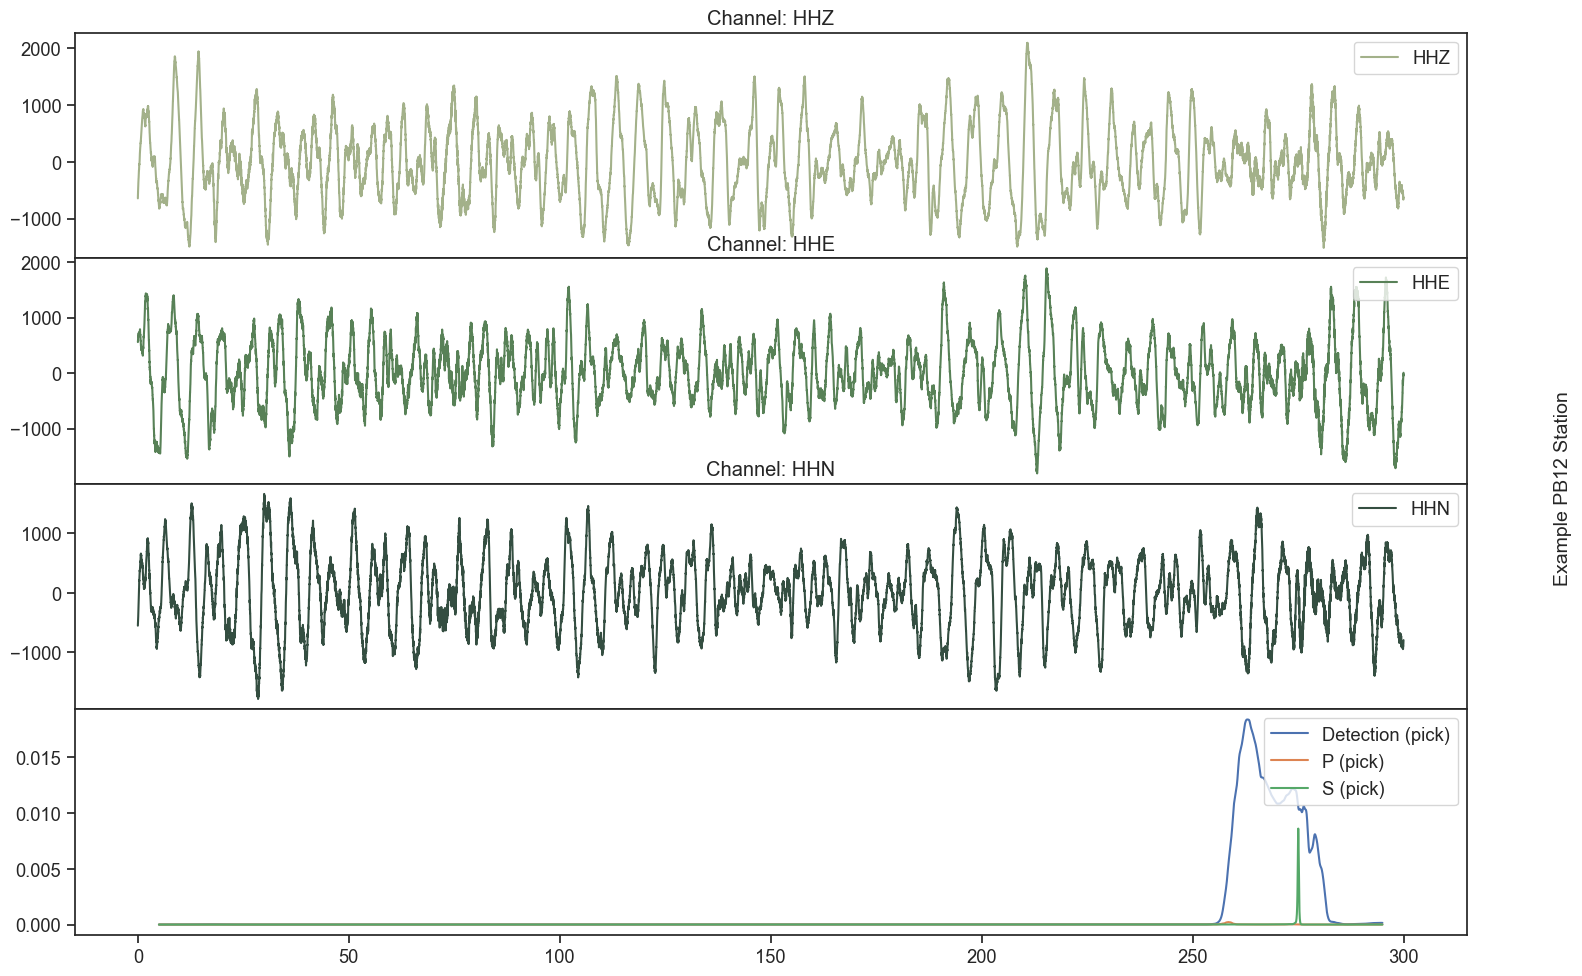

Plot for station PB12 with annotations saved.


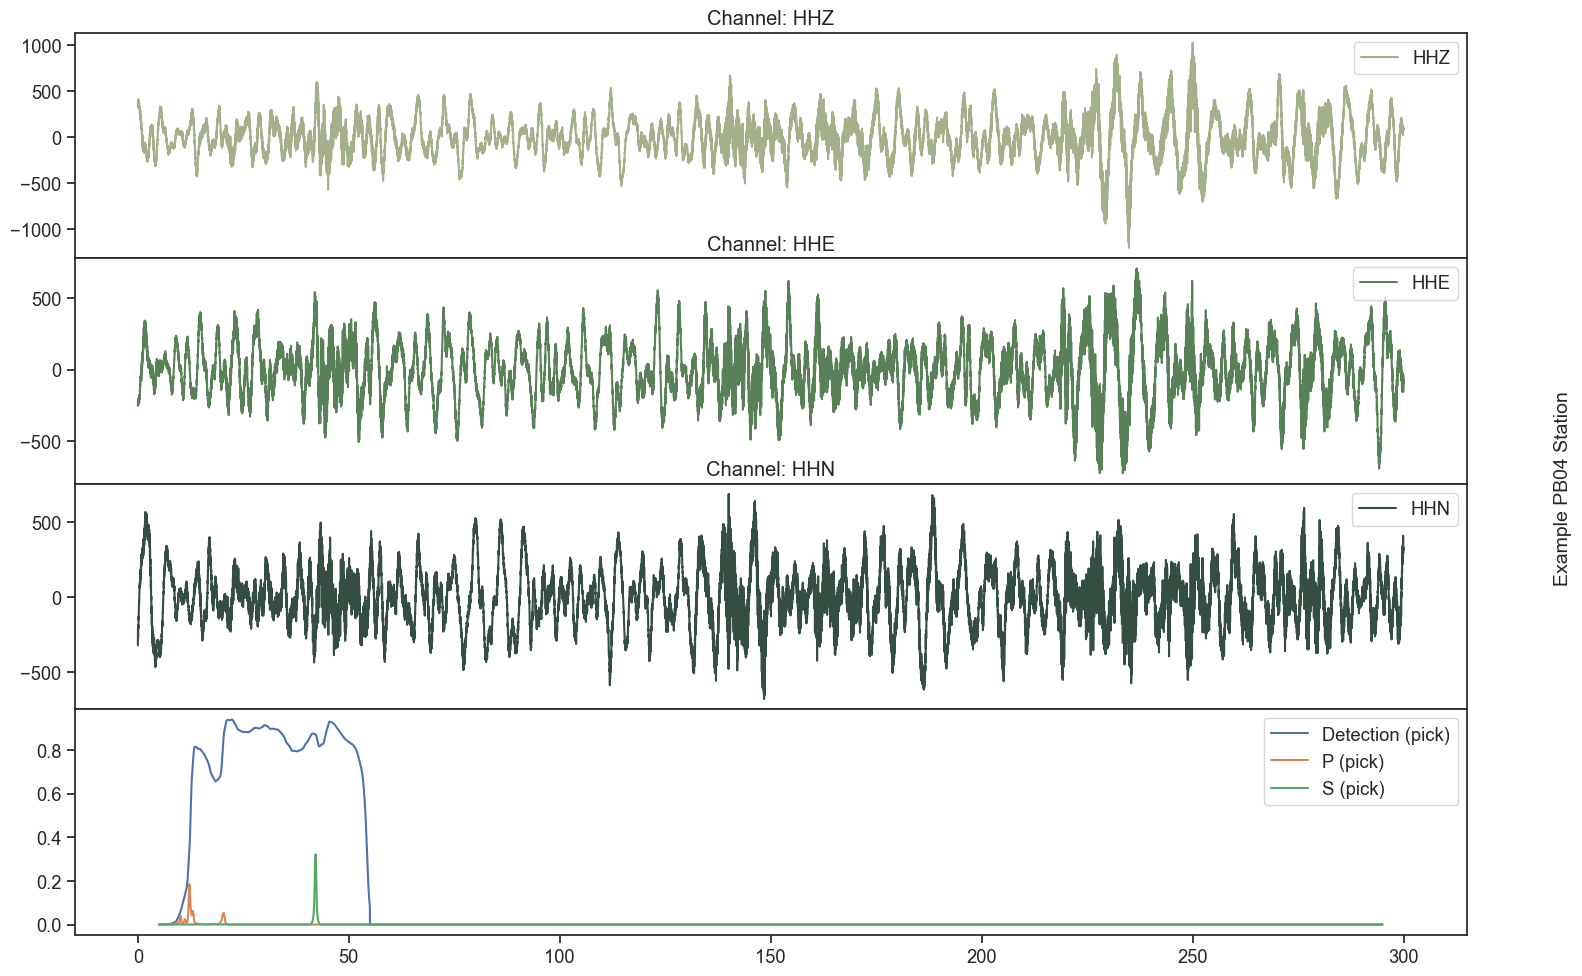

Plot for station PB04 with annotations saved.


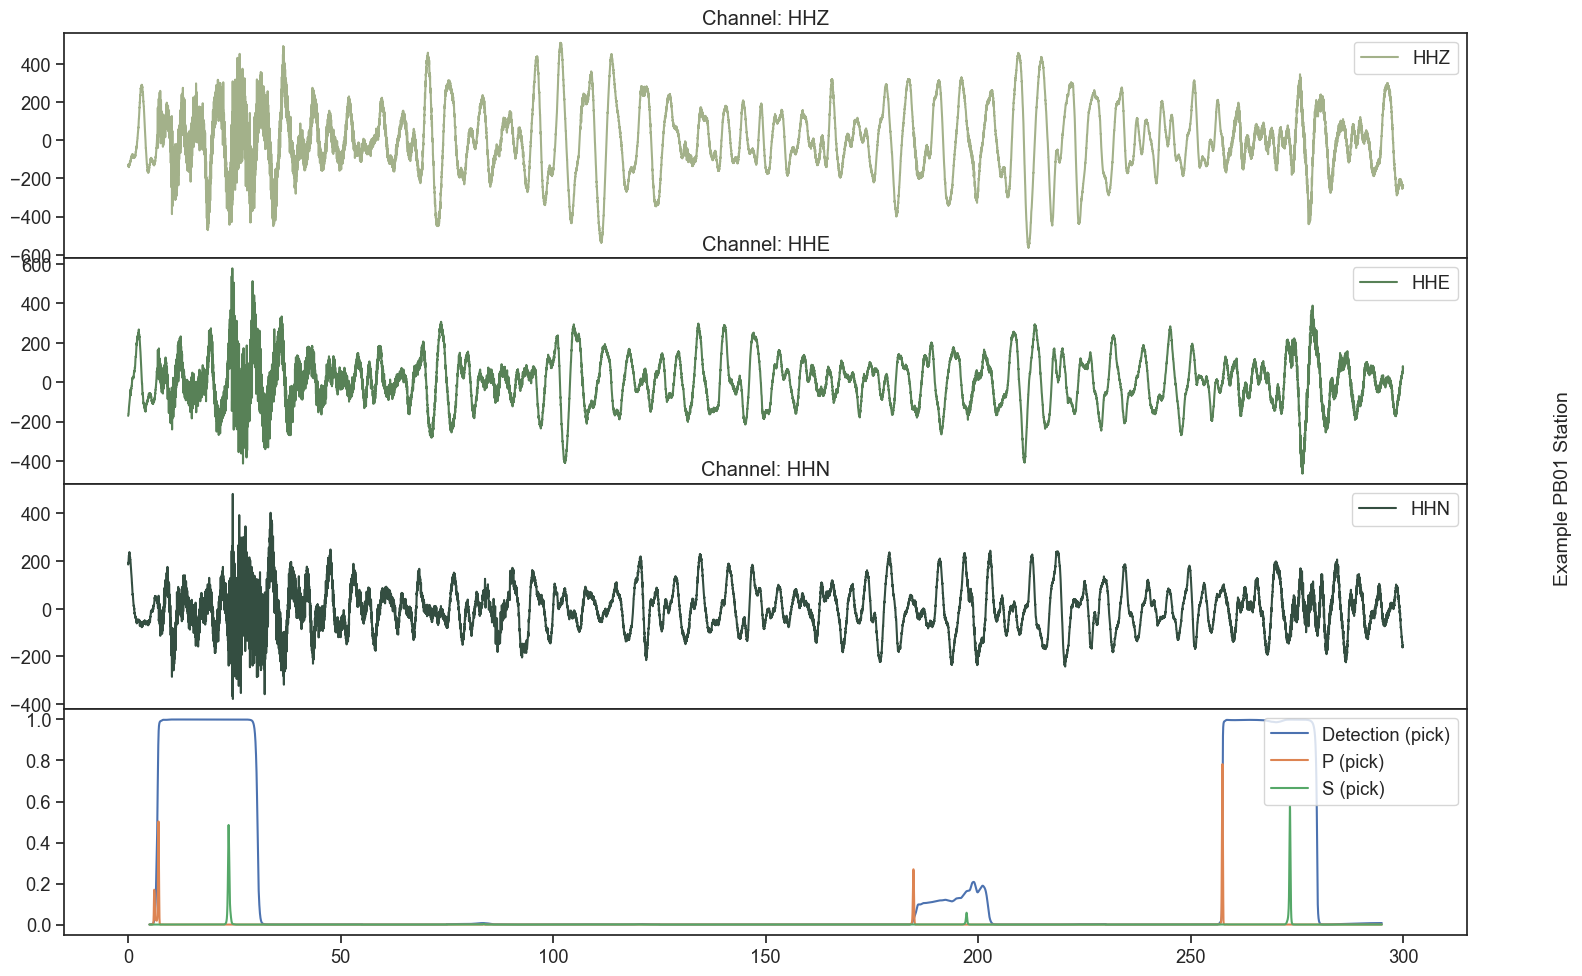

Plot for station PB01 with annotations saved.


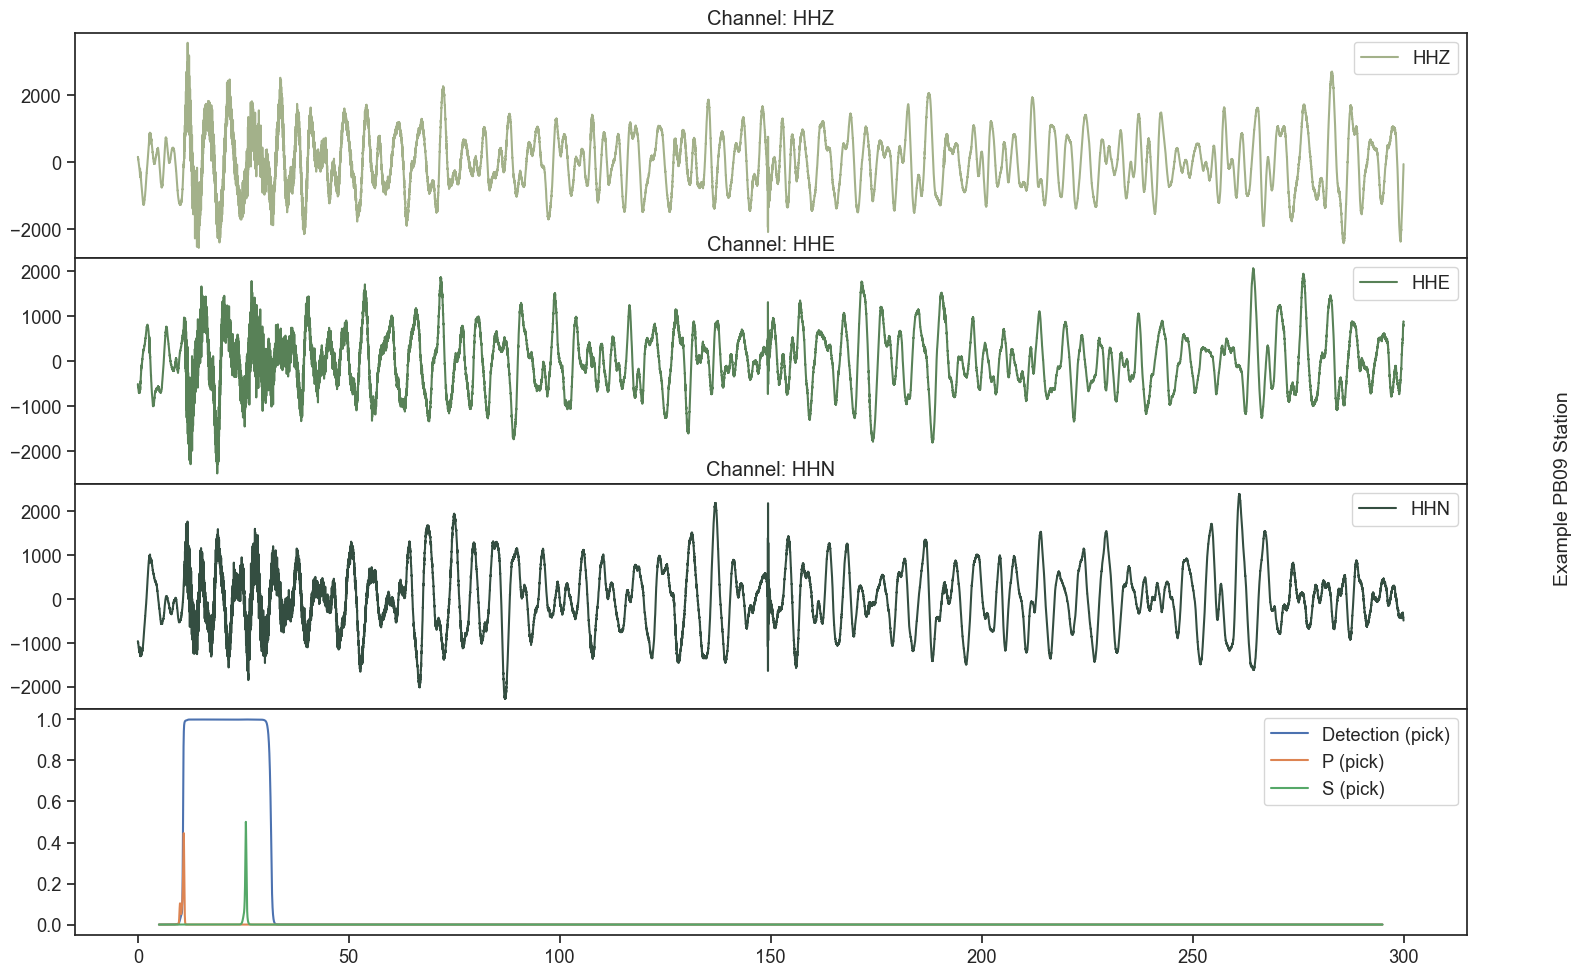

Plot for station PB09 with annotations saved.


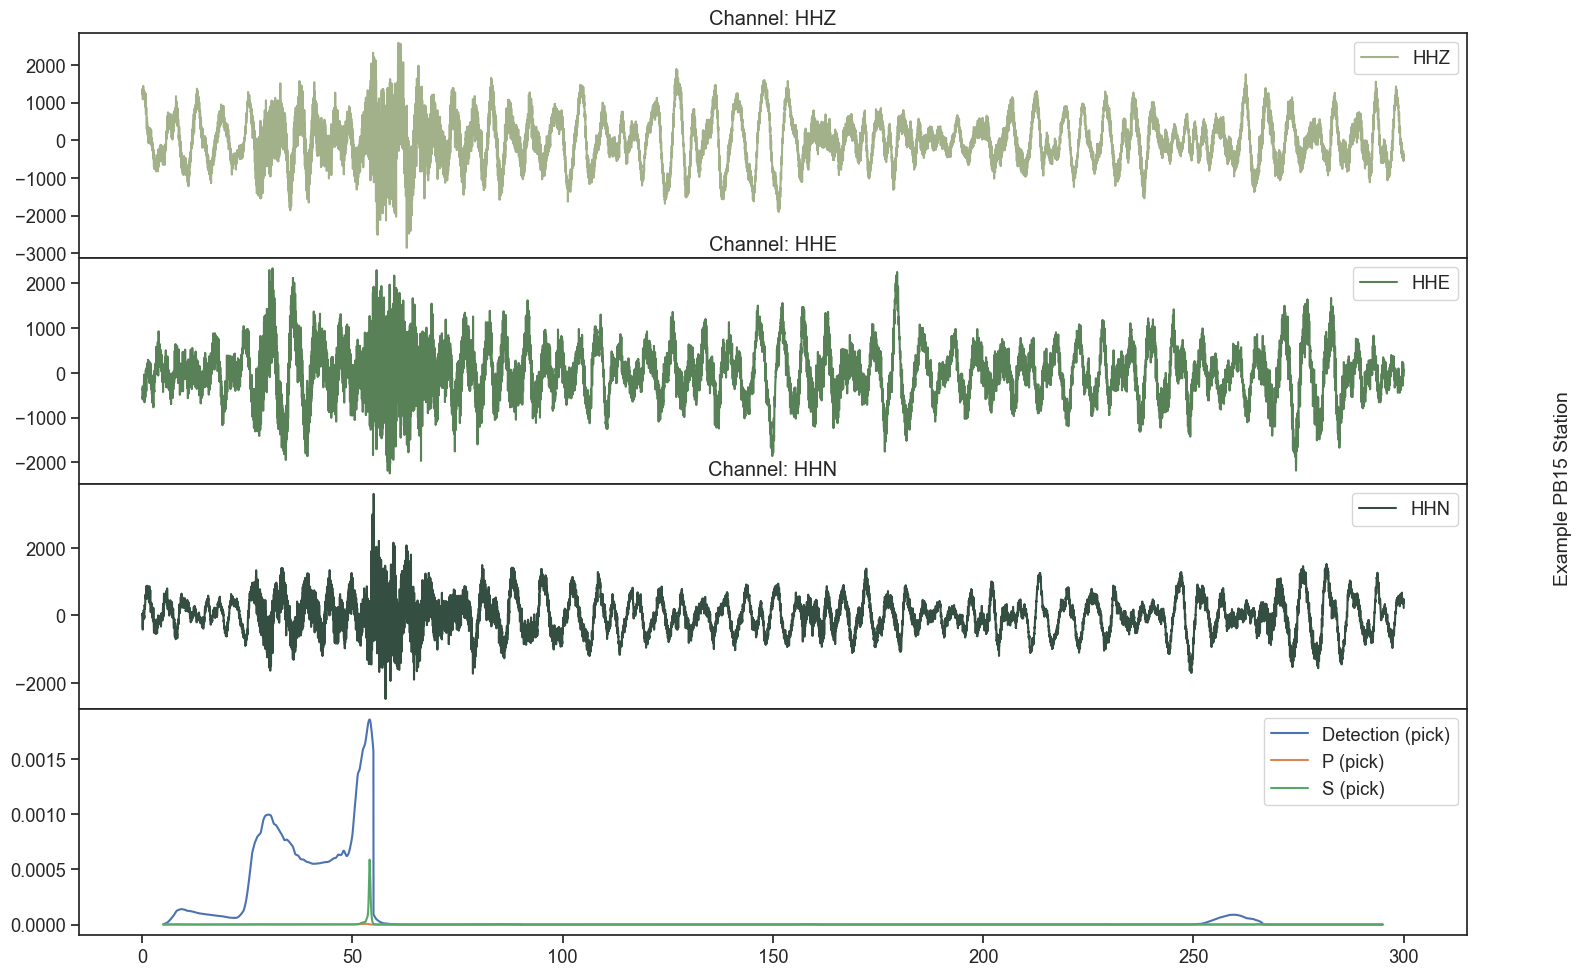

Plot for station PB15 with annotations saved.


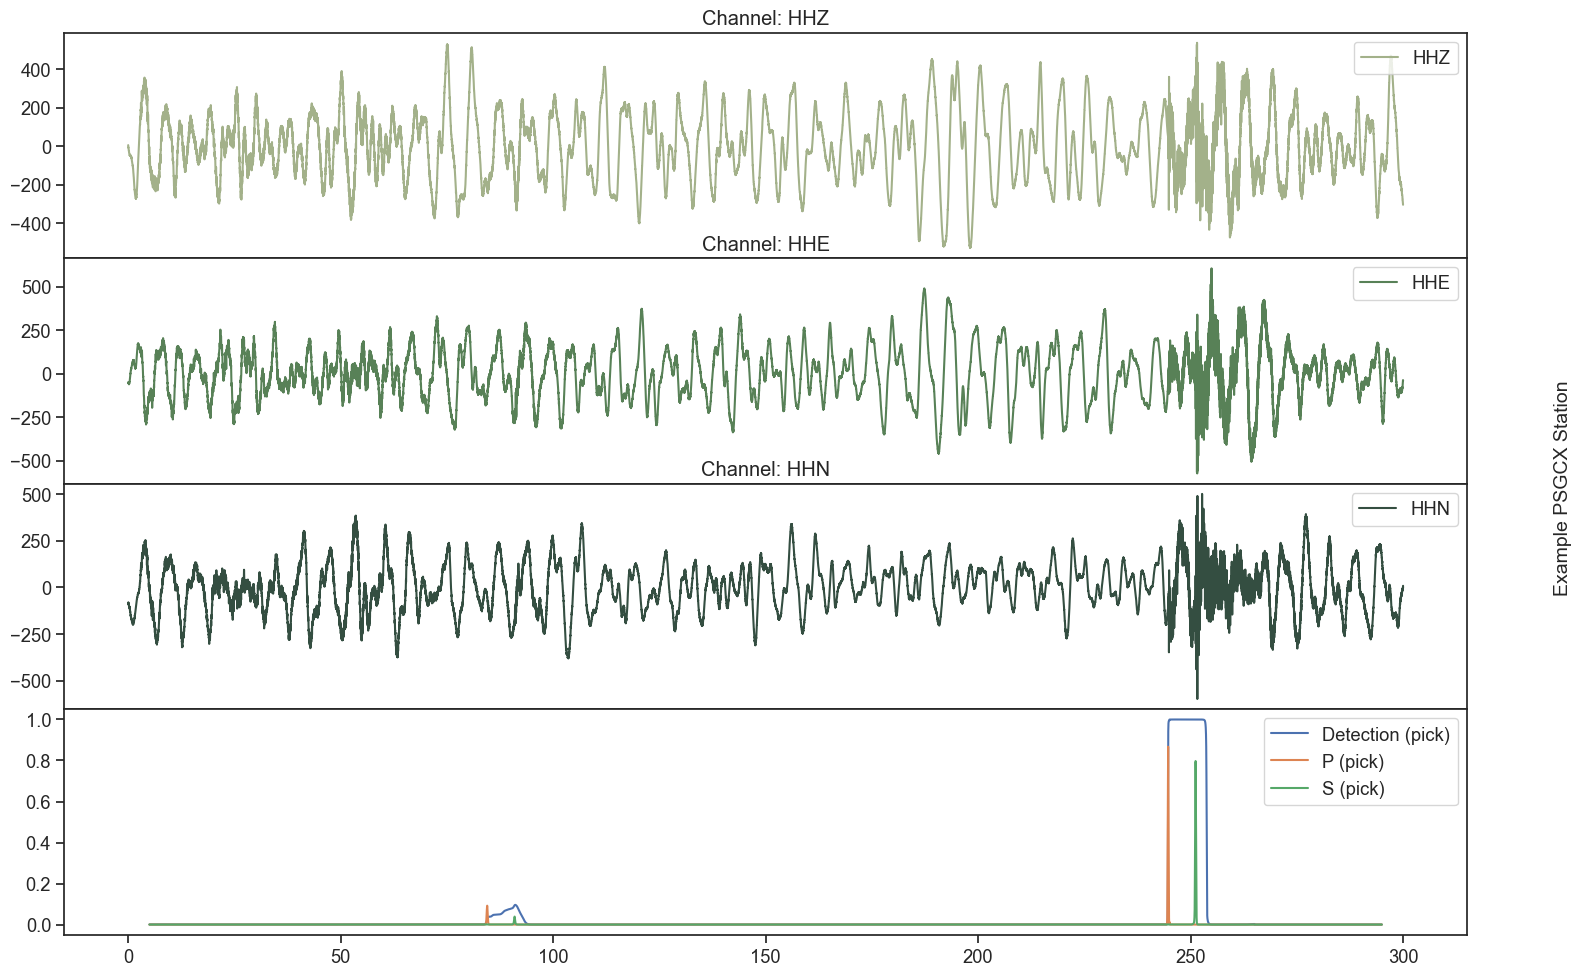

Plot for station PSGCX with annotations saved.


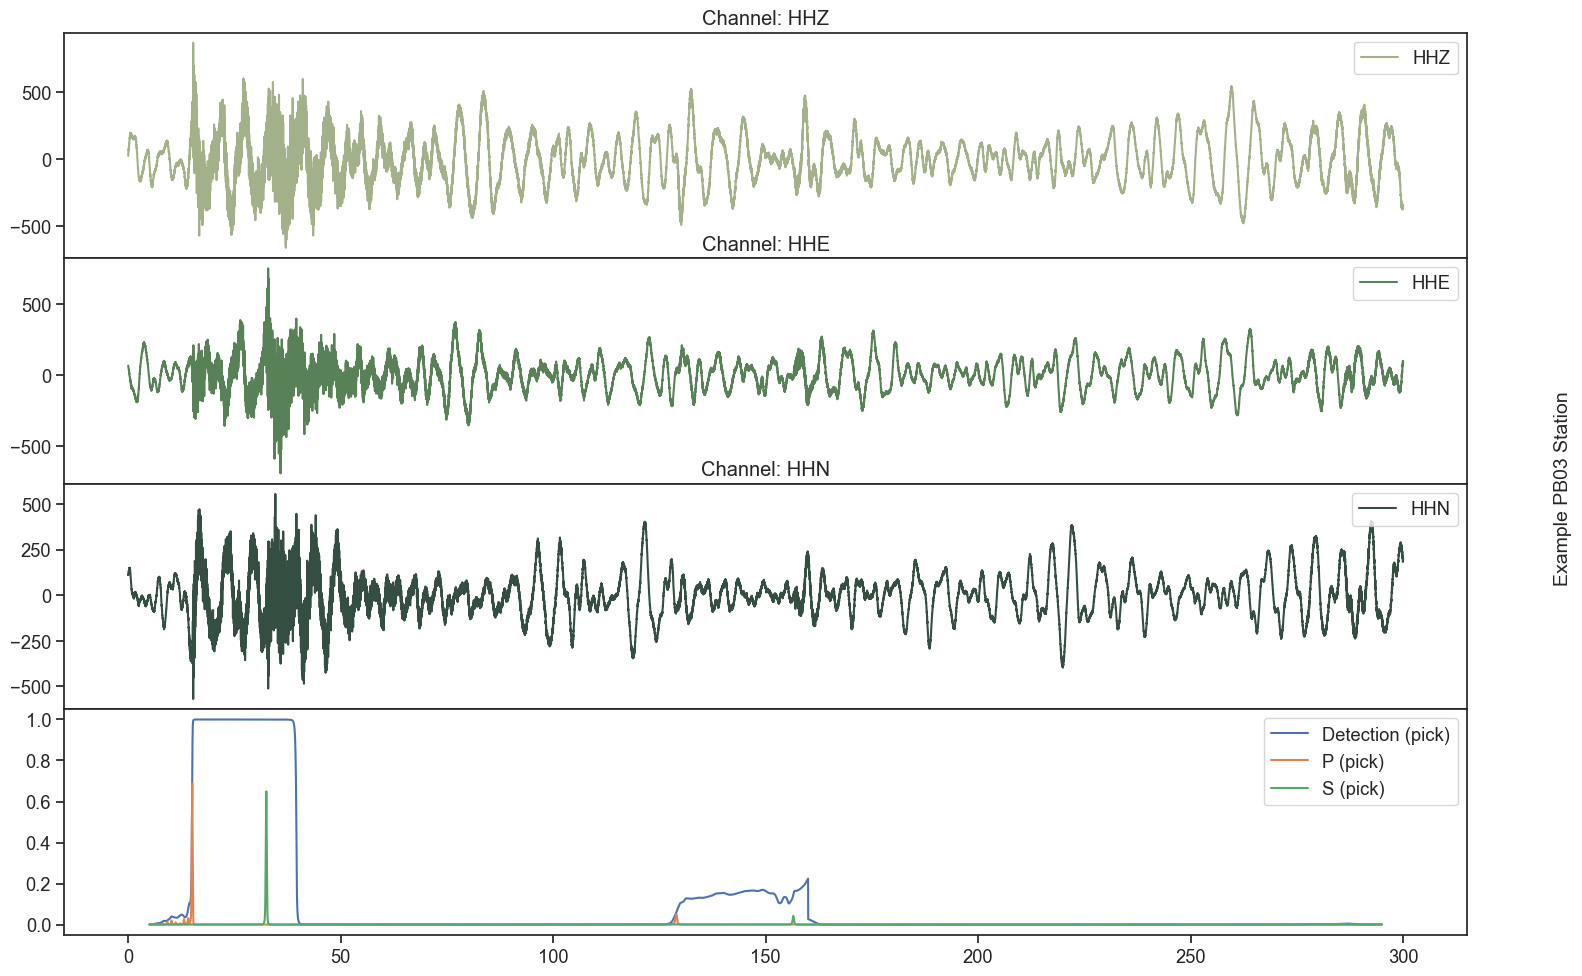

Plot for station PB03 with annotations saved.


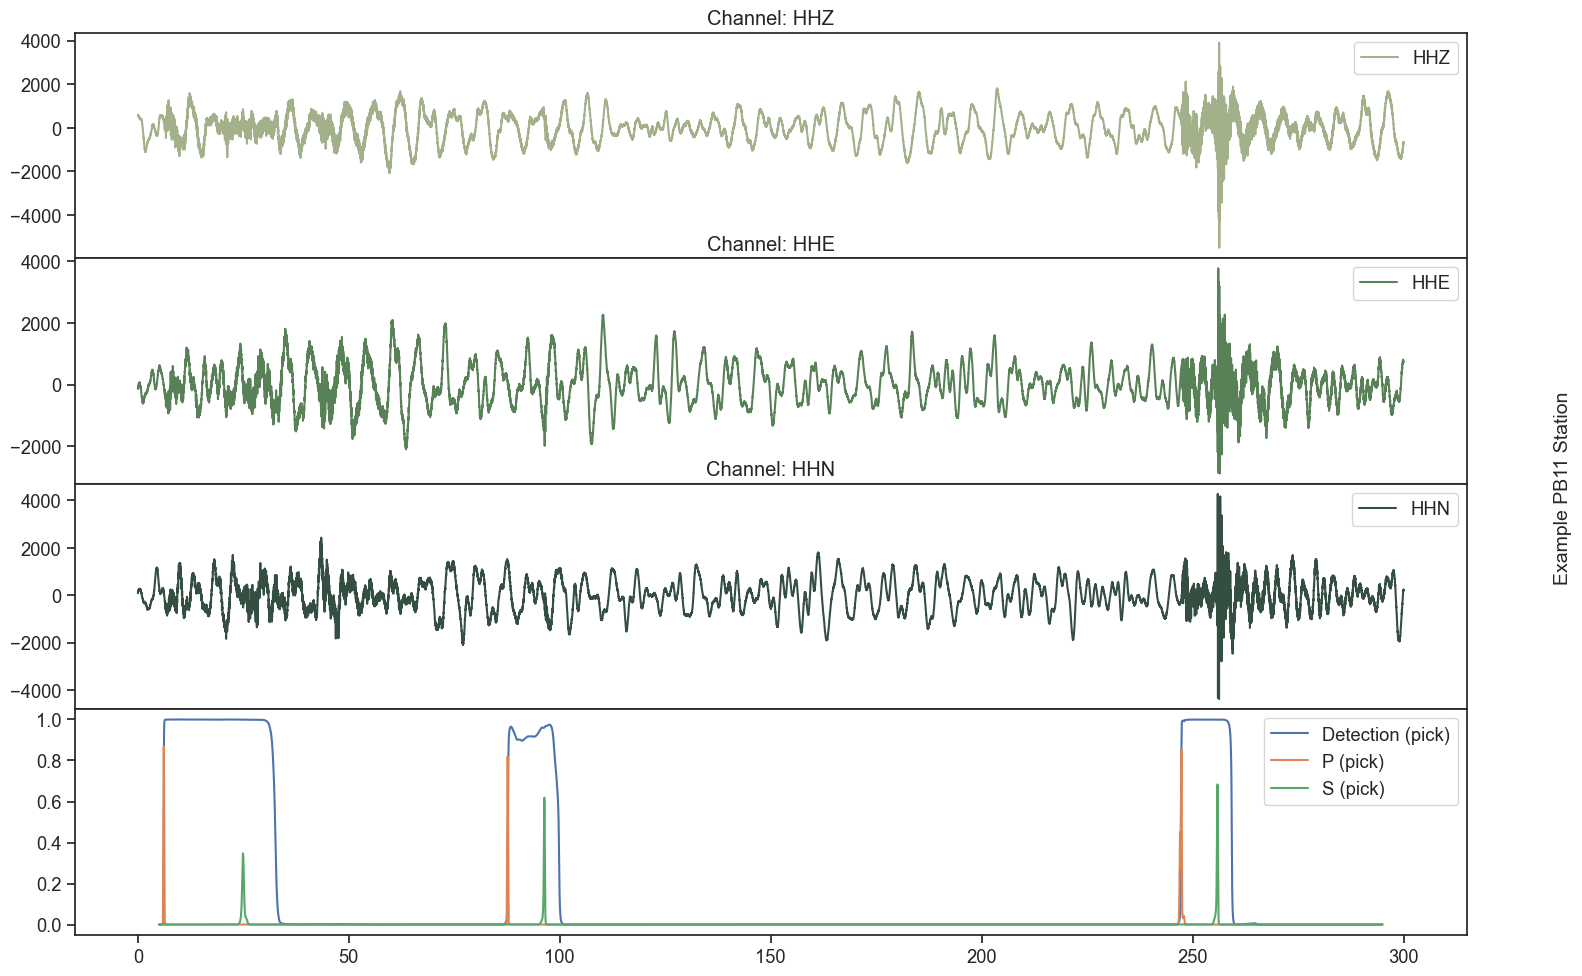

Plot for station PB11 with annotations saved.


In [7]:
import matplotlib.pyplot as plt

# Function to plot and save for each station
def plot_station_streams(station, stream, annotations=None):
    # Plot
    fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharex=True, gridspec_kw={"hspace": 0})
    ref_time = min([x.stats.starttime for x in stream])  # Reference time (min start time)

    # Line colors for each panel
    line_colors = ['#a3b18a', '#588157', '#344e41']  # Custom colors for channels

    # Plot each channel from the stream in a separate panel with demean and detrend
    for i in range(len(stream)):
        # Demean and detrend the data
        data_demeaned_detrended = stream[i].data - stream[i].data.mean()  # Demean
        data_demeaned_detrended = data_demeaned_detrended - (data_demeaned_detrended - data_demeaned_detrended.mean()).mean()  # Detrend

        axs[i].plot(
            stream[i].times(reftime=ref_time), data_demeaned_detrended, label=stream[i].stats.channel, color=line_colors[i % len(line_colors)]
        )
        axs[i].set_title(f"Channel: {stream[i].stats.channel}", loc='center')  # Title in lower left corner
        axs[i].legend(loc='upper right')  # Legend in upper right corner

    # Plot the annotations in the fourth panel if the channel is not noise
    if annotations:
        for i in range(3):
            if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
                axs[3].plot(
                    annotations[i].times(reftime=ref_time),
                    annotations[i].data,
                    label=annotations[i].stats.channel.split("_")[-1] + " (pick)",
                )
                axs[3].legend(loc='upper right')  # Legend in upper right corner

    # Add station name vertically on the right side of the figure
    fig.text(1.05, 0.5, "Example " + station + " Station", ha='center', va='center', rotation=90, fontsize=14)

    # Save the plot
    plt.tight_layout()
    plt.savefig(f"station_{station}_stream_EQT_Original_plot.png")
    plt.show()
    plt.close()

# Loop through each station and process annotations
for station, stream in station_streams.items():
    # Annotate the stream
    annotations = picker.annotate(stream, overlap=2500, blinding=[500, 500])
    
    # Plot the annotated stream
    plot_station_streams(station, stream, annotations)
    print(f"Plot for station {station} with annotations saved.")
